In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk
from jax.scipy.stats import norm
from jax.scipy.optimize import minimize
import gpjax as gpx
import time
import pickle as pkl
import seaborn as sns
import numpy as np

In [2]:
num_iterations = 40
num_instances = 400

In [3]:
EI_regret_arr = pkl.load(open("EI regrets.pkl",'rb'))
Gittins05_regret_arr = pkl.load(open("Gittins regrets (eps=0.0001, c=0.05).pkl",'rb'))
Gittins01_regret_arr = pkl.load(open("Gittins regrets (eps=0.00001, c=0.01).pkl",'rb'))
Gittins005_regret_arr = pkl.load(open("Gittins regrets (eps=0.00001, c=0.005).pkl",'rb'))
UCB_regret_arr = pkl.load(open("UCB regrets.pkl",'rb'))
TS_regret_arr = pkl.load(open("TS regrets.pkl",'rb'))

In [4]:
UCB01_regret_arr = pkl.load(open("UCB+EI regrets (beta=3, c=0.01).pkl",'rb'))
TS01_regret_arr = pkl.load(open("TS+EI regrets (c=0.01).pkl",'rb'))

In [5]:
UCB05_regret_arr = pkl.load(open("UCB+EI regrets (beta=3, c=0.05).pkl",'rb'))
TS05_regret_arr = pkl.load(open("TS+EI regrets (c=0.05).pkl",'rb'))

In [6]:
UCB005_regret_arr = pkl.load(open("UCB+EI regrets (beta=3, c=0.005).pkl",'rb'))
TS005_regret_arr = pkl.load(open("TS+EI regrets (c=0.005).pkl",'rb'))

In [7]:
ei_max_arr = pkl.load(open("maximum expected improvement.pkl",'rb'))

In [8]:
global_min_arr = pkl.load(open("global minimum values.pkl",'rb'))

In [9]:
best_observed05_arr = jnp.tile(global_min_arr[:, jnp.newaxis], (1, num_iterations+1)) + Gittins05_regret_arr
best_observed01_arr = jnp.tile(global_min_arr[:, jnp.newaxis], (1, num_iterations+1)) + Gittins01_regret_arr
best_observed005_arr = jnp.tile(global_min_arr[:, jnp.newaxis], (1, num_iterations+1)) + Gittins005_regret_arr

In [10]:
gittins05_min_arr = pkl.load(open("minimum Gittins index (eps=0.0001, c=0.05).pkl",'rb'))
gittins01_min_arr = pkl.load(open("minimum Gittins index (eps=0.00001, c=0.01).pkl",'rb'))
gittins005_min_arr = pkl.load(open("minimum Gittins index (eps=0.00001, c=0.005).pkl",'rb'))

In [11]:
ts01_ei_max_arr = pkl.load(open("maximum ts expected improvement (c=0.01).pkl",'rb'))
ucb01_ei_max_arr = pkl.load(open("maximum ucb expected improvement (beta=3, c=0.01).pkl",'rb'))

In [12]:
ts05_ei_max_arr = pkl.load(open("maximum ts expected improvement (c=0.05).pkl",'rb'))
ucb05_ei_max_arr = pkl.load(open("maximum ucb expected improvement (beta=3, c=0.05).pkl",'rb'))

In [13]:
ts005_ei_max_arr = pkl.load(open("maximum ts expected improvement (c=0.005).pkl",'rb'))
ucb005_ei_max_arr = pkl.load(open("maximum ucb expected improvement (beta=3, c=0.005).pkl",'rb'))

Text(0.5, 1.0, 'EI vs Gittins vs UCB vs TS (Matern12, 400 instances)')

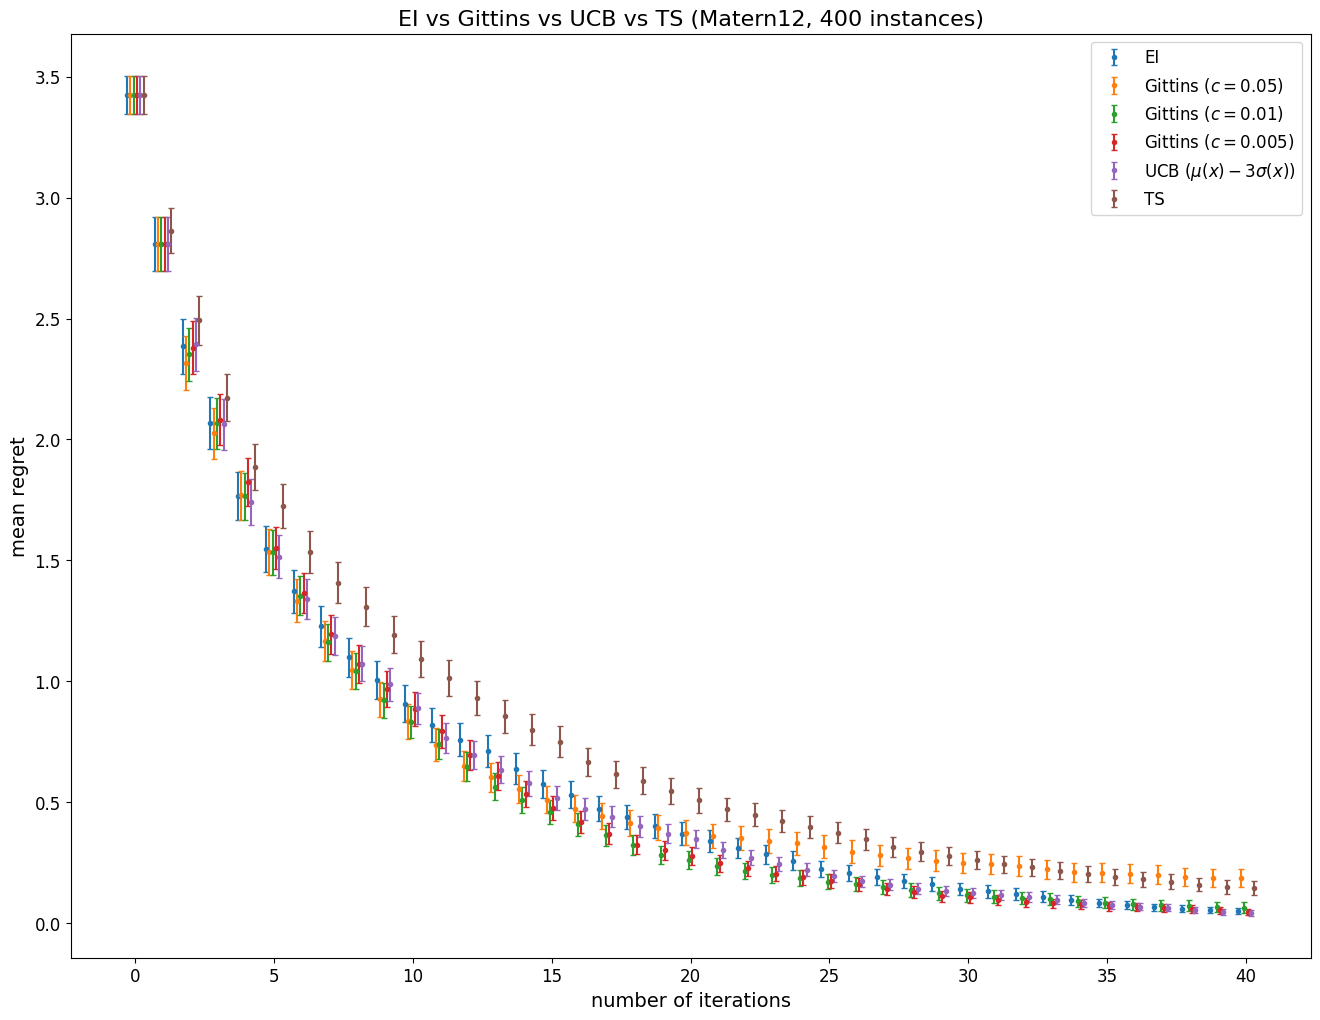

In [23]:
plt.figure(figsize=(16,12))

plt.errorbar(jnp.arange(num_iterations+1)-0.3, jnp.mean(EI_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(EI_regret_arr, axis=0)/jnp.sqrt(num_instances), label="EI", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)-0.18, jnp.mean(Gittins05_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(Gittins05_regret_arr, axis=0)/jnp.sqrt(num_instances), label="Gittins ($c=0.05$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)-0.06, jnp.mean(Gittins01_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(Gittins01_regret_arr, axis=0)/jnp.sqrt(num_instances), label="Gittins ($c=0.01$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)+0.06, jnp.mean(Gittins005_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(Gittins005_regret_arr, axis=0)/jnp.sqrt(num_instances), label="Gittins ($c=0.005$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)+0.18, jnp.mean(UCB_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(UCB_regret_arr, axis=0)/jnp.sqrt(num_instances), label="UCB ($\mu(x)-3\sigma(x)$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)+0.3, jnp.mean(TS_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(TS_regret_arr, axis=0)/jnp.sqrt(num_instances), label="TS", fmt='.', capsize=2)

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("number of iterations", fontsize=14)
plt.ylabel("mean regret", fontsize=14)
plt.title("EI vs Gittins vs UCB vs TS (Matern12, 400 instances)", fontsize=16)

Text(0.5, 1.0, 'TS vs TS+EI (Matern12, 400 instances)')

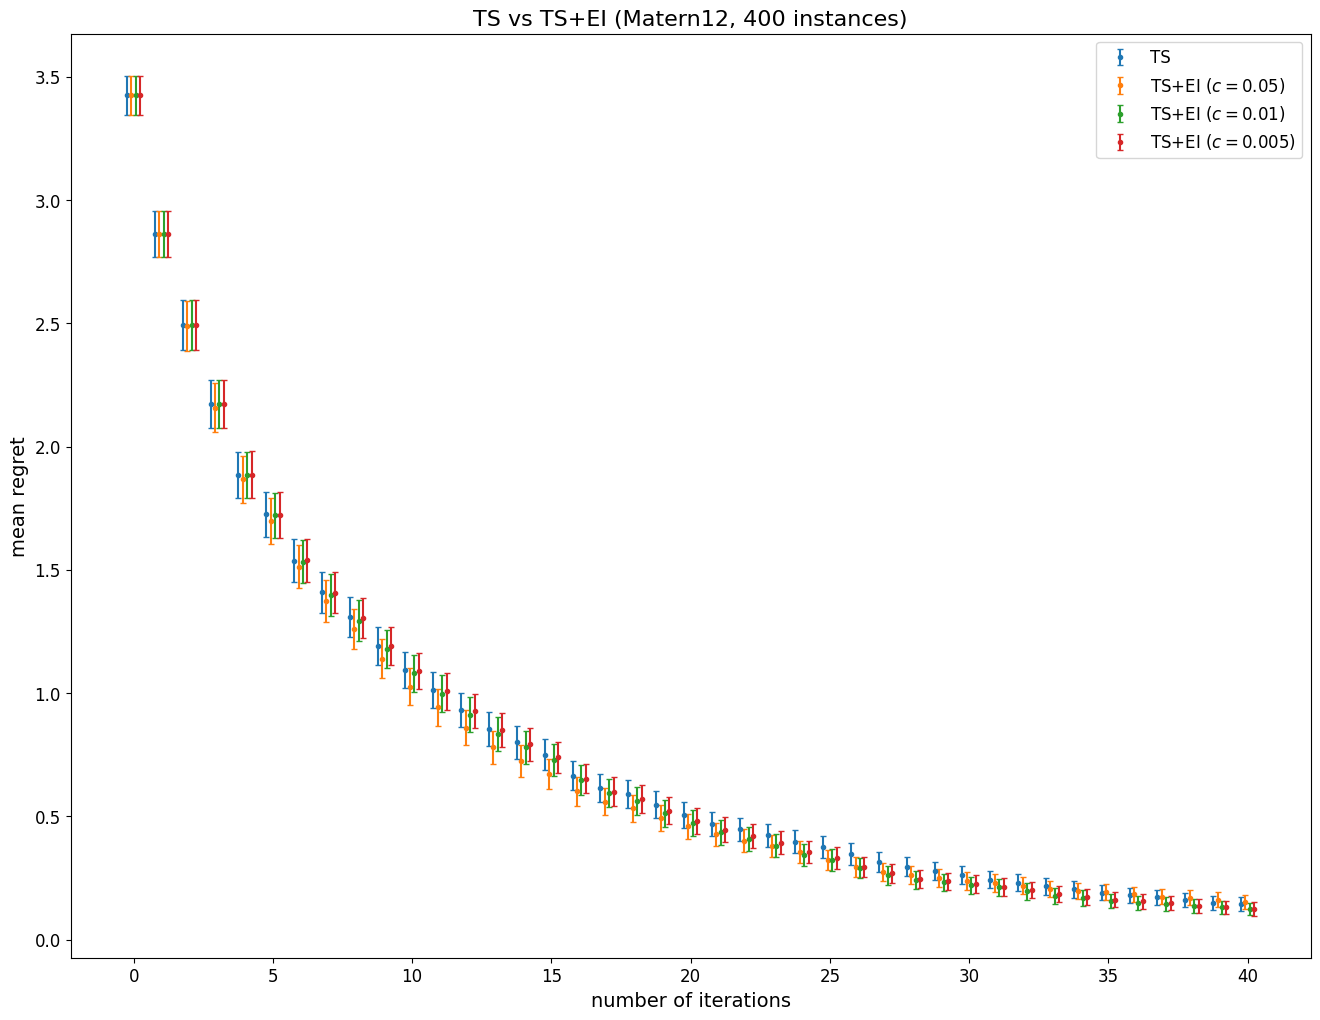

In [15]:
plt.figure(figsize=(16,12))

plt.errorbar(jnp.arange(num_iterations+1)-0.24, jnp.mean(TS_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(TS_regret_arr, axis=0)/jnp.sqrt(num_instances), label="TS", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)-0.08, jnp.mean(TS05_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(TS05_regret_arr, axis=0)/jnp.sqrt(num_instances), label="TS+EI ($c=0.05$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)+0.08, jnp.mean(TS01_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(TS01_regret_arr, axis=0)/jnp.sqrt(num_instances), label="TS+EI ($c=0.01$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)+0.24, jnp.mean(TS005_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(TS005_regret_arr, axis=0)/jnp.sqrt(num_instances), label="TS+EI ($c=0.005$)", fmt='.', capsize=2)

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("number of iterations", fontsize=14)
plt.ylabel("mean regret", fontsize=14)
plt.title("TS vs TS+EI (Matern12, 400 instances)", fontsize=16)

Text(0.5, 1.0, 'UCB vs UCB+EI (beta=3, Matern12, 400 instances)')

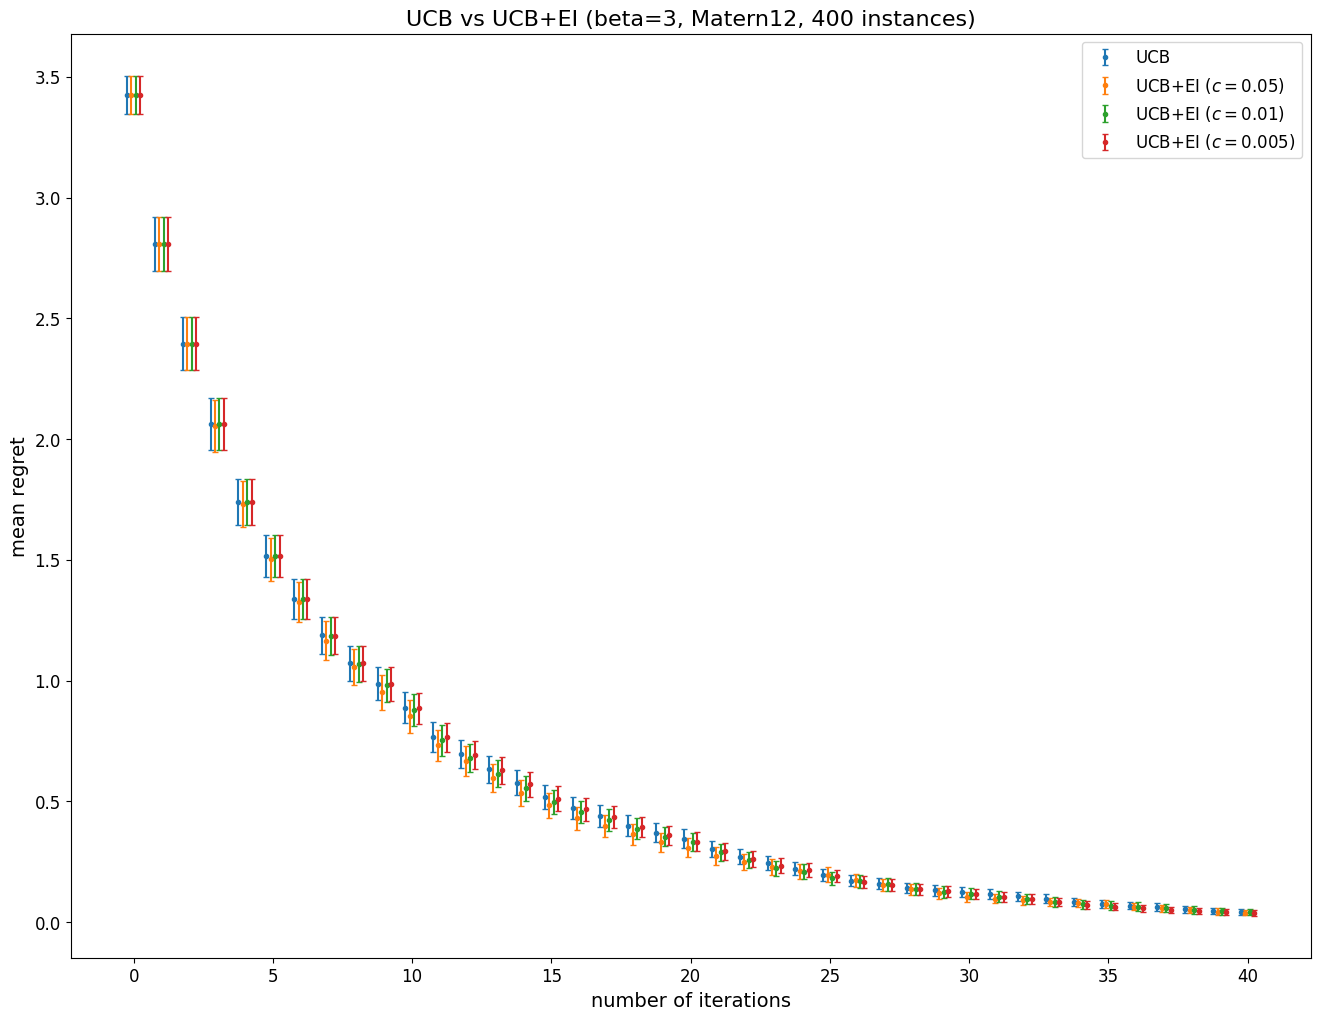

In [24]:
plt.figure(figsize=(16,12))

plt.errorbar(jnp.arange(num_iterations+1)-0.24, jnp.mean(UCB_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(UCB_regret_arr, axis=0)/jnp.sqrt(num_instances), label="UCB", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)-0.08, jnp.mean(UCB05_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(UCB05_regret_arr, axis=0)/jnp.sqrt(num_instances), label="UCB+EI ($c=0.05$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)+0.08, jnp.mean(UCB01_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(UCB01_regret_arr, axis=0)/jnp.sqrt(num_instances), label="UCB+EI ($c=0.01$)", fmt='.', capsize=2)
plt.errorbar(jnp.arange(num_iterations+1)+0.24, jnp.mean(UCB005_regret_arr, axis=0)[:num_iterations+1], yerr=1.96*jnp.std(UCB005_regret_arr, axis=0)/jnp.sqrt(num_instances), label="UCB+EI ($c=0.005$)", fmt='.', capsize=2)

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("number of iterations", fontsize=14)
plt.ylabel("mean regret", fontsize=14)
plt.title("UCB vs UCB+EI (beta=3, Matern12, 400 instances)", fontsize=16)

In [17]:
# Traditional (EI, UCB, TS) stopping rule: max expected improvement < query cost
def EI_stopping(query_cost, EI_regret_arr, ei_max_arr):
    EI_stopping_time = jnp.append(jnp.zeros((num_instances,1), dtype=int), jnp.cumsum(jnp.cumprod(ei_max_arr >= query_cost, axis=1), axis=1)[:,:-1], axis=1)
    EI_cost_regret = jnp.take_along_axis(EI_regret_arr, EI_stopping_time, axis=1) + query_cost*EI_stopping_time
    EI_stopping_percentage = jnp.sum(1-jnp.cumprod(ei_max_arr >= query_cost, axis=1),axis=0)/(num_instances/100)
    return EI_stopping_time, EI_cost_regret, EI_stopping_percentage

In [18]:
# Gittins stopping rule: min Gittins index < best observed value
def Gittins_stopping(query_cost, global_min_arr, Gittins_regret_arr, gittins_min_arr):
    best_observed_arr = jnp.tile(global_min_arr[:, jnp.newaxis], (1, num_iterations+1)) + Gittins_regret_arr
    Gittins_stopping_time = jnp.append(jnp.zeros((num_instances,1), dtype=int), jnp.cumsum(jnp.cumprod(best_observed_arr >= gittins_min_arr, axis=1), axis=1)[:,:-1], axis=1)
    Gittins_cost_regret = jnp.take_along_axis(Gittins_regret_arr, Gittins_stopping_time, axis=1) + query_cost*Gittins_stopping_time
    Gittins_stopping_percentage = jnp.sum(1-jnp.cumprod(best_observed_arr >= gittins_min_arr, axis=1),axis=0)/(num_instances/100)
    return Gittins_stopping_time, Gittins_cost_regret, Gittins_stopping_percentage

Text(0.15, 0.355, 'Gittins stopping rule: best observed value < min unvisited Gittins index')

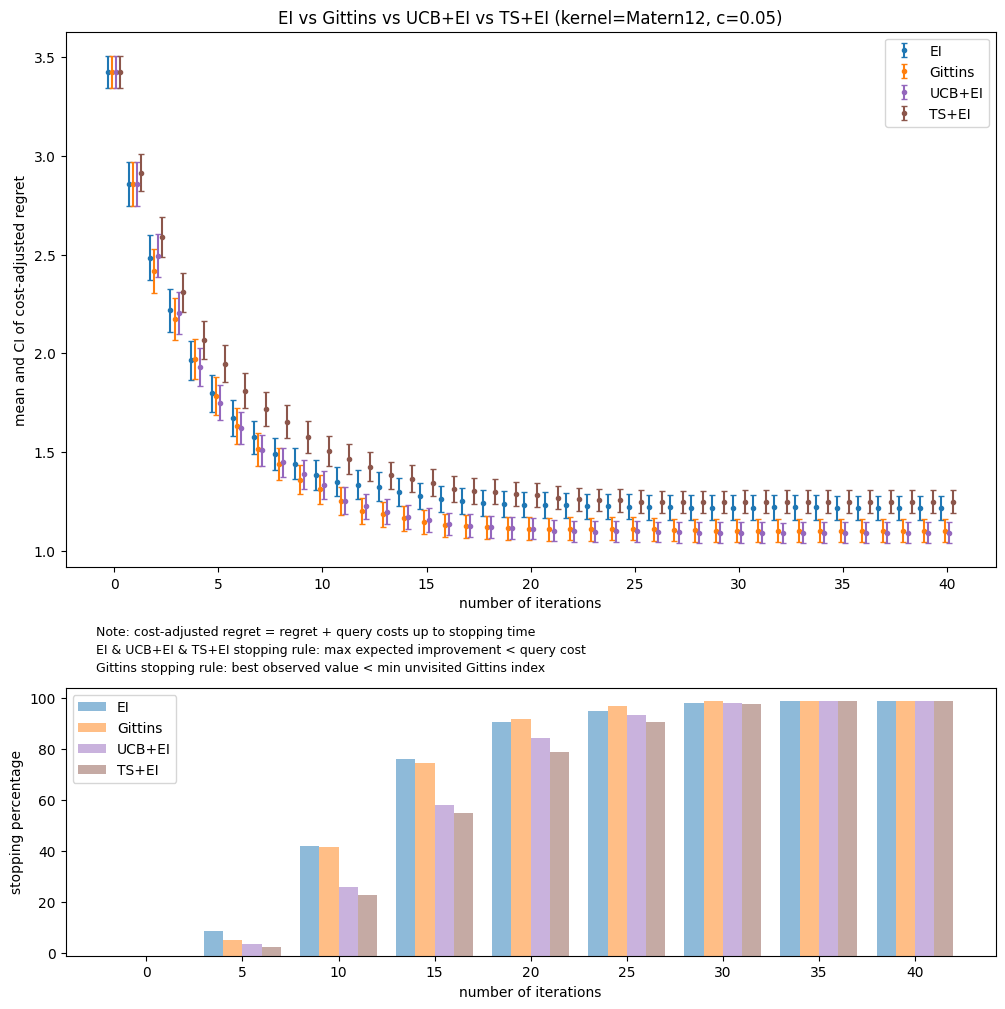

In [19]:
query_cost = 0.05

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2,1]}, figsize=(12, 12))

EI_stopping_time, EI_cost_regret, EI_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=EI_regret_arr[:,:num_iterations+1], ei_max_arr=ei_max_arr[:,:num_iterations+1])
Gittins05_stopping_time, Gittins05_cost_regret, Gittins05_stopping_percentage = Gittins_stopping(query_cost=query_cost, global_min_arr=global_min_arr, Gittins_regret_arr=Gittins05_regret_arr[:,:num_iterations+1], gittins_min_arr=gittins05_min_arr[:,:num_iterations+1])
TS05_stopping_time, TS05_cost_regret, TS05_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=TS05_regret_arr[:,:num_iterations+1], ei_max_arr=ts05_ei_max_arr[:,:num_iterations+1])
UCB05_stopping_time, UCB05_cost_regret, UCB05_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=UCB05_regret_arr[:,:num_iterations+1], ei_max_arr=ucb05_ei_max_arr[:,:num_iterations+1])

ax[0].set_title("EI vs Gittins vs UCB+EI vs TS+EI (kernel=Matern12, c="+str(query_cost)+")")
ax[0].errorbar(jnp.arange(0, num_iterations+1)-0.3, jnp.mean(EI_cost_regret, axis=0), label='EI', yerr=1.96*jnp.std(EI_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:blue', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)-0.1, jnp.mean(Gittins05_cost_regret, axis=0), label='Gittins', yerr=1.96*jnp.std(Gittins05_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:orange', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)+0.1, jnp.mean(UCB05_cost_regret, axis=0), label='UCB+EI', yerr=1.96*jnp.std(UCB05_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:purple', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)+0.3, jnp.mean(TS05_cost_regret, axis=0), label='TS+EI', yerr=1.96*jnp.std(TS05_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:brown', fmt='.', capsize=2)
ax[0].legend()
ax[0].set_xlabel("number of iterations")
ax[0].set_ylabel("mean and CI of cost-adjusted regret")

ax[1].bar(jnp.arange(0, num_iterations+1, 5)-1.5, EI_stopping_percentage[::5], width=1, label='EI', color='tab:blue', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)-0.5, Gittins05_stopping_percentage[::5], width=1, label='Gittins', color='tab:orange', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)+0.5, UCB05_stopping_percentage[::5], width=1, label='UCB+EI', color='tab:purple', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)+1.5, TS05_stopping_percentage[::5], width=1, label='TS+EI', color='tab:brown', bottom=-1, alpha=0.5)

ax[1].set_xticks(jnp.arange(0, num_iterations+1, 5))
ax[1].set_yticks(jnp.arange(0, 101, 20))
ax[1].set_xlabel("number of iterations")
ax[1].set_ylabel("stopping percentage")
ax[1].legend()

plt.subplots_adjust(hspace=0.3)
fig.text(0.15, 0.385, 'Note: cost-adjusted regret = regret + query costs up to stopping time', ha='left', va='top', fontsize=9)
fig.text(0.15, 0.37, 'EI & UCB+EI & TS+EI stopping rule: max expected improvement < query cost', ha='left', va='top', fontsize=9)
fig.text(0.15, 0.355, 'Gittins stopping rule: best observed value < min unvisited Gittins index', ha='left', va='top', fontsize=9)

Text(0.15, 0.355, 'Gittins stopping rule: best observed value < min unvisited Gittins index')

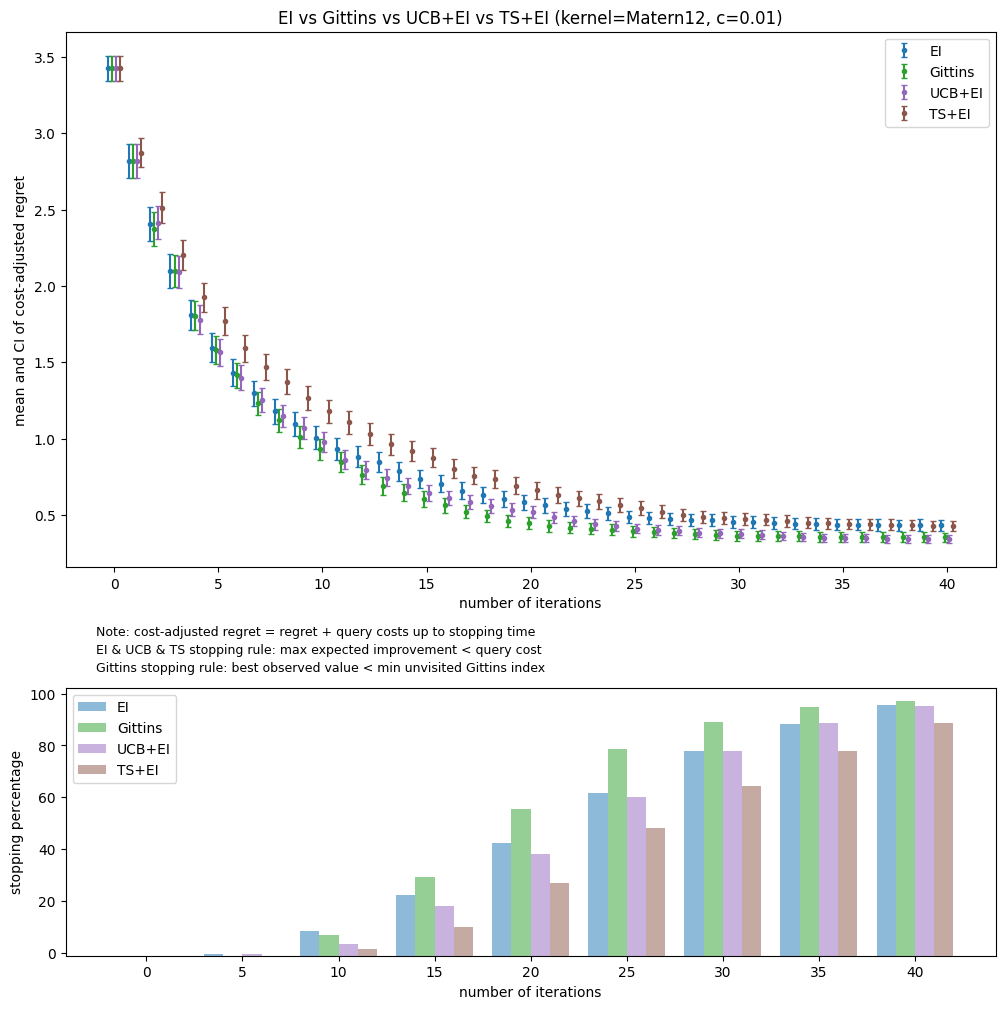

In [20]:
query_cost = 0.01

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2,1]}, figsize=(12, 12))

EI_stopping_time, EI_cost_regret, EI_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=EI_regret_arr[:,:num_iterations+1], ei_max_arr=ei_max_arr[:,:num_iterations+1])
Gittins01_stopping_time, Gittins01_cost_regret, Gittins01_stopping_percentage = Gittins_stopping(query_cost=query_cost, global_min_arr=global_min_arr, Gittins_regret_arr=Gittins01_regret_arr[:,:num_iterations+1], gittins_min_arr=gittins01_min_arr[:,:num_iterations+1])
TS01_stopping_time, TS01_cost_regret, TS01_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=TS01_regret_arr[:,:num_iterations+1], ei_max_arr=ts01_ei_max_arr[:,:num_iterations+1])
UCB01_stopping_time, UCB01_cost_regret, UCB01_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=UCB01_regret_arr[:,:num_iterations+1], ei_max_arr=ucb01_ei_max_arr[:,:num_iterations+1])

ax[0].set_title("EI vs Gittins vs UCB+EI vs TS+EI (kernel=Matern12, c="+str(query_cost)+")")
ax[0].errorbar(jnp.arange(0, num_iterations+1)-0.3, jnp.mean(EI_cost_regret, axis=0), label='EI', yerr=1.96*jnp.std(EI_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:blue', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)-0.1, jnp.mean(Gittins01_cost_regret, axis=0), label='Gittins', yerr=1.96*jnp.std(Gittins01_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:green', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)+0.1, jnp.mean(UCB01_cost_regret, axis=0), label='UCB+EI', yerr=1.96*jnp.std(UCB01_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:purple', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)+0.3, jnp.mean(TS01_cost_regret, axis=0), label='TS+EI', yerr=1.96*jnp.std(TS01_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:brown', fmt='.', capsize=2)
ax[0].legend()
ax[0].set_xlabel("number of iterations")
ax[0].set_ylabel("mean and CI of cost-adjusted regret")

ax[1].bar(jnp.arange(0, num_iterations+1, 5)-1.5, EI_stopping_percentage[::5], width=1, label='EI', color='tab:blue', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)-0.5, Gittins01_stopping_percentage[::5], width=1, label='Gittins', color='tab:green', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)+0.5, UCB01_stopping_percentage[::5], width=1, label='UCB+EI', color='tab:purple', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)+1.5, TS01_stopping_percentage[::5], width=1, label='TS+EI', color='tab:brown', bottom=-1, alpha=0.5)

ax[1].set_xticks(jnp.arange(0, num_iterations+1, 5))
ax[1].set_yticks(jnp.arange(0, 101, 20))
ax[1].set_xlabel("number of iterations")
ax[1].set_ylabel("stopping percentage")
ax[1].legend()

plt.subplots_adjust(hspace=0.3)
fig.text(0.15, 0.385, 'Note: cost-adjusted regret = regret + query costs up to stopping time', ha='left', va='top', fontsize=9)
fig.text(0.15, 0.37, 'EI & UCB & TS stopping rule: max expected improvement < query cost', ha='left', va='top', fontsize=9)
fig.text(0.15, 0.355, 'Gittins stopping rule: best observed value < min unvisited Gittins index', ha='left', va='top', fontsize=9)
# fig.text(0.15, 0.35, 'TS stopping rule: min sampled value - best observed value < query cost', ha='left', va='top', fontsize=9)

Text(0, 0.5, 'mean and CI of cost-adjusted regret')

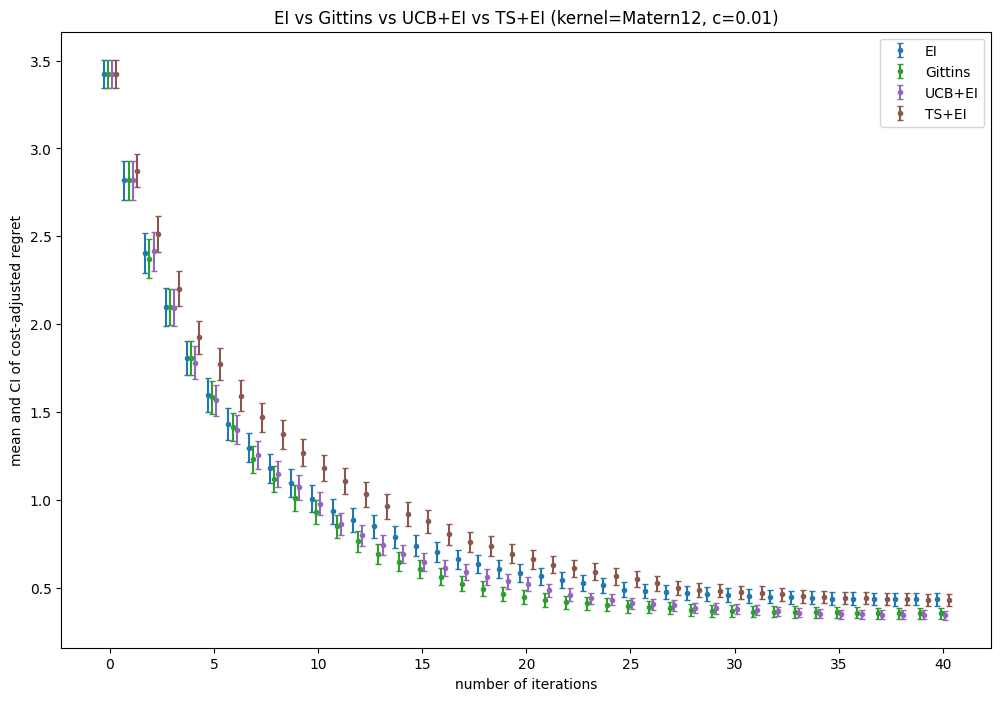

In [27]:
query_cost = 0.01

EI_stopping_time, EI_cost_regret, EI_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=EI_regret_arr[:,:num_iterations+1], ei_max_arr=ei_max_arr[:,:num_iterations+1])
Gittins01_stopping_time, Gittins01_cost_regret, Gittins01_stopping_percentage = Gittins_stopping(query_cost=query_cost, global_min_arr=global_min_arr, Gittins_regret_arr=Gittins01_regret_arr[:,:num_iterations+1], gittins_min_arr=gittins01_min_arr[:,:num_iterations+1])
TS01_stopping_time, TS01_cost_regret, TS01_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=TS01_regret_arr[:,:num_iterations+1], ei_max_arr=ts01_ei_max_arr[:,:num_iterations+1])
UCB01_stopping_time, UCB01_cost_regret, UCB01_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=UCB01_regret_arr[:,:num_iterations+1], ei_max_arr=ucb01_ei_max_arr[:,:num_iterations+1])

plt.figure(figsize=(12,8))
plt.title("EI vs Gittins vs UCB+EI vs TS+EI (kernel=Matern12, c="+str(query_cost)+")")
plt.errorbar(jnp.arange(0, num_iterations+1)-0.3, jnp.mean(EI_cost_regret, axis=0), label='EI', yerr=1.96*jnp.std(EI_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:blue', fmt='.', capsize=2)
plt.errorbar(jnp.arange(0, num_iterations+1)-0.1, jnp.mean(Gittins01_cost_regret, axis=0), label='Gittins', yerr=1.96*jnp.std(Gittins01_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:green', fmt='.', capsize=2)
plt.errorbar(jnp.arange(0, num_iterations+1)+0.1, jnp.mean(UCB01_cost_regret, axis=0), label='UCB+EI', yerr=1.96*jnp.std(UCB01_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:purple', fmt='.', capsize=2)
plt.errorbar(jnp.arange(0, num_iterations+1)+0.3, jnp.mean(TS01_cost_regret, axis=0), label='TS+EI', yerr=1.96*jnp.std(TS01_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:brown', fmt='.', capsize=2)
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("mean and CI of cost-adjusted regret")


Text(0.15, 0.355, 'Gittins stopping rule: best observed value < min unvisited Gittins index')

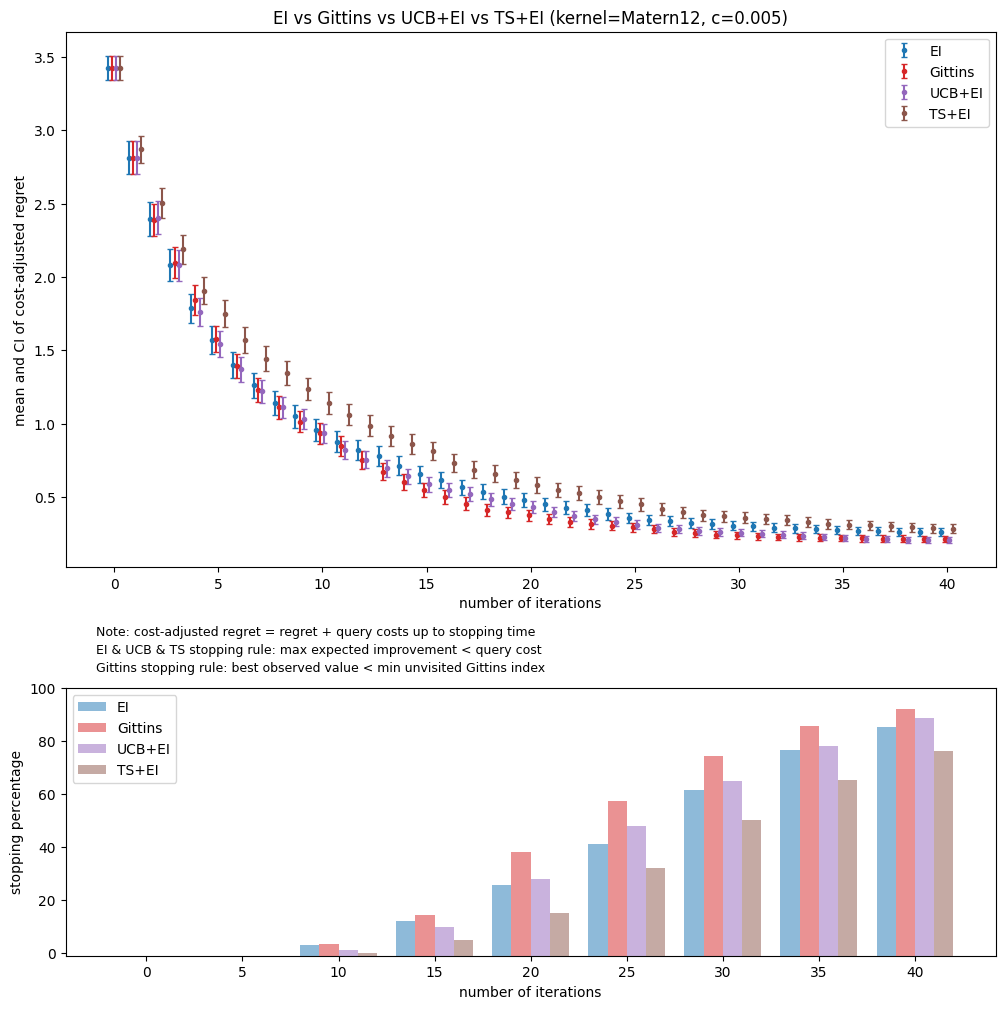

In [21]:
query_cost = 0.005

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2,1]}, figsize=(12, 12))

EI_stopping_time, EI_cost_regret, EI_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=EI_regret_arr[:,:num_iterations+1], ei_max_arr=ei_max_arr[:,:num_iterations+1])
Gittins005_stopping_time, Gittins005_cost_regret, Gittins005_stopping_percentage = Gittins_stopping(query_cost=query_cost, global_min_arr=global_min_arr, Gittins_regret_arr=Gittins005_regret_arr[:,:num_iterations+1], gittins_min_arr=gittins005_min_arr[:,:num_iterations+1])
TS005_stopping_time, TS005_cost_regret, TS005_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=TS005_regret_arr[:,:num_iterations+1], ei_max_arr=ts005_ei_max_arr[:,:num_iterations+1])
UCB005_stopping_time, UCB005_cost_regret, UCB005_stopping_percentage = EI_stopping(query_cost=query_cost, EI_regret_arr=UCB005_regret_arr[:,:num_iterations+1], ei_max_arr=ucb005_ei_max_arr[:,:num_iterations+1])

ax[0].set_title("EI vs Gittins vs UCB+EI vs TS+EI (kernel=Matern12, c="+str(query_cost)+")")
ax[0].errorbar(jnp.arange(0, num_iterations+1)-0.3, jnp.mean(EI_cost_regret, axis=0), label='EI', yerr=1.96*jnp.std(EI_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:blue', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)-0.1, jnp.mean(Gittins005_cost_regret, axis=0), label='Gittins', yerr=1.96*jnp.std(Gittins005_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:red', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)+0.1, jnp.mean(UCB005_cost_regret, axis=0), label='UCB+EI', yerr=1.96*jnp.std(UCB005_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:purple', fmt='.', capsize=2)
ax[0].errorbar(jnp.arange(0, num_iterations+1)+0.3, jnp.mean(TS005_cost_regret, axis=0), label='TS+EI', yerr=1.96*jnp.std(TS005_cost_regret, axis=0)/jnp.sqrt(num_instances), color='tab:brown', fmt='.', capsize=2)
ax[0].legend()
ax[0].set_xlabel("number of iterations")
ax[0].set_ylabel("mean and CI of cost-adjusted regret")

ax[1].bar(jnp.arange(0, num_iterations+1, 5)-1.5, EI_stopping_percentage[::5], width=1, label='EI', color='tab:blue', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)-0.5, Gittins005_stopping_percentage[::5], width=1, label='Gittins', color='tab:red', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)+0.5, UCB005_stopping_percentage[::5], width=1, label='UCB+EI', color='tab:purple', bottom=-1, alpha=0.5)
ax[1].bar(jnp.arange(0, num_iterations+1, 5)+1.5, TS005_stopping_percentage[::5], width=1, label='TS+EI', color='tab:brown', bottom=-1, alpha=0.5)

ax[1].set_xticks(jnp.arange(0, num_iterations+1, 5))
ax[1].set_yticks(jnp.arange(0, 101, 20))
ax[1].set_xlabel("number of iterations")
ax[1].set_ylabel("stopping percentage")
ax[1].legend()

plt.subplots_adjust(hspace=0.3)
fig.text(0.15, 0.385, 'Note: cost-adjusted regret = regret + query costs up to stopping time', ha='left', va='top', fontsize=9)
fig.text(0.15, 0.37, 'EI & UCB & TS stopping rule: max expected improvement < query cost', ha='left', va='top', fontsize=9)
fig.text(0.15, 0.355, 'Gittins stopping rule: best observed value < min unvisited Gittins index', ha='left', va='top', fontsize=9)
# fig.text(0.15, 0.35, 'TS stopping rule: min sampled value - best observed value < query cost', ha='left', va='top', fontsize=9)